## Reinforcement Learning

In [280]:
import numpy as np 
import pickle 
from collections import namedtuple, defaultdict
from itertools import combinations
from random import choice, random
from tqdm.auto import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt


In [3]:
State = namedtuple('State', ['x','o'])

In [4]:
MAGIC = [2,7,6,
         9,5,1,
         4,3,8]

In [5]:
def print_board(pos):
    for r in range(3):
        for c in range(3):
            i = r*3+c
            if MAGIC[i] in pos.x:
                print('X', end='')
            elif MAGIC[i] in pos.o:
                print('O', end='')
            else:
                print('.', end='')
        print()
    print()     


In [6]:
def win(elements):
    """Check if elements is winning"""
    return any(sum(c)== 15 for c in combinations(elements,3))

def state_value(state: State):
    """Evaluate position: +1 first player wins"""
    if win(state.x):
        return 1
    elif win(state.o):
        return -1
    else:
        return 0

In [13]:
Action = namedtuple('Action', ['player','move'])

In [14]:
def win(elements):
    """Check if elements is winning"""
    return any(sum(c)== 15 for c in combinations(elements,3))

In [15]:
def action_value(state: State):
    """Evaluate position: +1 first player wins"""
    if win(state.x):
        return 1
    elif win(state.o):
        return -1
    else:
        return 0

In [16]:
def random_game_Q():
    trajectory = list()
    state= State(set(),set())
    available = set(range(1,9+1))
    while available:
    
        x = choice(list(available))
        action = Action('x',x)
        
        trajectory.append(tuple((deepcopy(state),deepcopy(action))))
        
        available.remove(x)
        state.x.add(x)
        if win(state.x) or not available:
            trajectory.append(tuple((deepcopy(state),deepcopy(Action('o',None)))))
            break
        


        o = choice(list(available))
        action = Action('o',o)
        trajectory.append(tuple((deepcopy(state),deepcopy(action))))
        
        available.remove(o)
        state.o.add(o)
        if win(state.o):
            trajectory.append(tuple((deepcopy(state),deepcopy(Action('x',None)))))
            break
        

    return trajectory

In [17]:
def epsilon_greedy_policy(available,state, Q_table, epsilon):
    if random() < epsilon:
        # Explore: Choose a random action (random empty cell on the board)
        action = choice(list(available))  

    else:
        # Exploit: Choose the action with the highest Q-value for the current state
        hashable_state = State(frozenset(state.x),frozenset(state.o))
        action =  max(available, key=lambda x: Q_table[(tuple((hashable_state, Action('x',x))))])  # Choose action with the highest Q-value
        
    return action

### Q-learning

In [292]:
def update_Q(Q, state_action, next_state, reward, alpha, gamma):
    # Q-learning update rule
    # select min Q-value for the next state: the next state is the opponents turn so this 
    # strategy considers an opponent who plays the best move according to the current policy
    max_next_Q = (np.min(val for key, val in Q.items() if key[0] == next_state)) if next_state in Q else 0  
    current_Q = Q.get(state_action, 0)  # Current Q-value for the current state-action pair
    new_Q = current_Q + alpha * (reward + gamma * (max_next_Q) - current_Q)  # Updated Q-value
    Q[state_action] = new_Q  # Update Q-value in the Q-table
    return Q  # Return the updated Q-table

#### Exploit symmetries

In [23]:
# used to change the state representation to one that's simpler to compute symmetries for
# X:1, O:2, not selected: 0
def change_representation(state, single_array=True):
    if single_array:
        game = np.zeros(9)
        for x in state.x:
            game[MAGIC.index(x)]=1
        for o in state.o:
            game[MAGIC.index(o)]=2
        return game
    else:
        game=State(set(),set())
        for i in range(len(state)):
            if state[i]==1:
                game.x.add(MAGIC[i])
            elif state[i]==2:
                game.o.add(MAGIC[i])
        return game

In [24]:
def rotate_90(sequence):
    # Rotate a sequence by 90 degrees clockwise
    return [sequence[6], sequence[3], sequence[0], sequence[7], sequence[4], sequence[1], sequence[8], sequence[5], sequence[2]]

# Function to reflect the sequence horizontally
def reflect_horizontal(sequence):
    # Reflect a sequence horizontally
    return [sequence[2], sequence[1], sequence[0], sequence[5], sequence[4], sequence[3], sequence[8], sequence[7], sequence[6]]

# Function to reflect the sequence vertically
def reflect_vertical(sequence):
    # Reflect a sequence vertically
    return [sequence[6], sequence[7], sequence[8], sequence[3], sequence[4], sequence[5], sequence[0], sequence[1], sequence[2]]


In [25]:
def get_game_metrics(game):
    #compute the metrics used to evaluate which base case to use 
    # for each set of symmetries (more info in the README)
    metrics=[0,0,1,1]
    for i in range(len(game)):
        if game[i]==1:
            metrics[0]+= i+1
            metrics[2]*= i+1
        elif game[i] ==2:
            metrics[1]+= i+1
            metrics[3]*= i+1

    return metrics

In [388]:
#compute the base case for a given state
def compute_base_case(state):

    #change representation
    game=change_representation(state,True)

    #compute symmetries
    symmetries=list()
    rotations=[]
    rotations.append(game)
    rotated= deepcopy(game)
    for _ in range(3):
        rotated = rotate_90(rotated)
        rotations.append(rotated)

    symmetries.extend(rotations)
    for r in rotations:
        symmetries.append(reflect_vertical(r))

   
    #select the base case 
    metrics_dict={}
    for i in range(len(symmetries)):

        metrics_dict[i]=get_game_metrics(symmetries[i])
    l=dict(sorted(metrics_dict.items(), key=lambda x: x[1]))
    
    base_case_idx = list(dict(sorted(metrics_dict.items(), key=lambda x: x[1])).keys())[0]
    # select the base case and go back to the previous state representation
    return change_representation(symmetries[base_case_idx],False)

In [395]:
def play_game(Q_table, first, sym=False):
    state= State(set(),set())
    available = set(range(1,9+1))
    while available:
        
        if first:
            hashable_state = State(frozenset(state.x),frozenset(state.o))
            x = max(available, key=lambda x: Q_table[(tuple((hashable_state, Action('x',x))))])
        else:
            x = choice(list(available))
        state.x.add(x)

        if sym:
            state = compute_base_case(state)
        available.remove(x)
        
        if win(state.x):
            return 1
        if not available:
            break
        
        if first:
            o = choice(list(available))
        else:
            hashable_state = State(frozenset(state.x),frozenset(state.o))
            o = min(available, key=lambda o: Q_table[(tuple((hashable_state, Action('o',o))))])
        state.o.add(o)
        available.remove(o)
        if sym:
            state = compute_base_case(state)
        if win(state.o):
            return -1
        if not available:
            break
    return 0
    

In [397]:
def evaluate_Agent(Q_table,first,sym):
    won=0
    lost=0
    draw=0
    games= 100_000
    winnings=np.zeros(games)
    for i in tqdm(range(games)):
        
        w = play_game(Q_table,first,sym)
        if w==1:
            won+=1
        elif w==0:
            draw+=1
        elif w==-1:
            lost+=1
            
        winnings[i]=won/(i+1)
    perc_won=won/games
    perc_lost=lost/games
    perc_draw=draw/games

    print("The percentage of won/lost/drawn games for X is: ",perc_won,perc_lost,perc_draw)
    print("The size of the table is :", len(Q_table))
    plt.plot(range(1, games + 1), winnings)
    plt.title('Percentage of won games over the iterations')
    plt.xlabel('Number of games played')
    plt.ylabel('"%" of Won games')
    plt.show()

In [336]:
def agent_game_Q(Q_table, epsilon=0.15, same_policy=False, print_game = False,sym=False):
    trajectory = list()
    state= State(set(),set())
    available = set(range(1,9+1))
    while available:
        
        if print_game:
            print_board(state)

        #agent move
        x = epsilon_greedy_policy(available,state,Q_table,epsilon)
        action = Action('x',x)
        
        trajectory.append(tuple((deepcopy(state),deepcopy(action))))
        
        available.remove(x)
        state.x.add(x)

        if sym:
            state= compute_base_case(state)

        if win(state.x) or not available:
            trajectory.append(tuple((deepcopy(state),deepcopy(Action('o',None)))))
            if print_game:
                print_board(state)
            break
        
        if print_game:
            print_board(state)

        # opponent move
        if same_policy:
            o = epsilon_greedy_policy(available,state,Q_table,epsilon)
        else:
            o = choice(list(available))
        action = Action('o',o)
        trajectory.append(tuple((deepcopy(state),deepcopy(action))))
        
        available.remove(o)
        state.o.add(o)

        if sym:
            state= compute_base_case(state)
            
        if win(state.o):
            trajectory.append(tuple((deepcopy(state),deepcopy(Action('x',None)))))
            if print_game:
                print_board(state)
            break
        
        

    return trajectory

In [394]:
def Q_learning( sym=False, on_policy=False,alpha = 0.4,gamma = 1):

    Q_table = defaultdict(float)
    
    for _ in tqdm(range(100_000)):
        if on_policy:
            trajectory = agent_game_Q(Q_table,sym=sym)
        else:
            trajectory = random_game_Q()

        final_reward = action_value(trajectory[-1][0])

        for state, action in trajectory:
            player_state_map = {'x': deepcopy(state.x), 'o': deepcopy(state.o)}
            
            hashable_state = State(frozenset(state.x),frozenset(state.o))
            state_action = tuple((hashable_state,action))
            #select next state according to the action of this step
            next_state = player_state_map[action.player].add(action.move)
            if sym and next_state:
                next_state=compute_base_case(next_state)
            #update Q table
            Q_table = update_Q(Q_table,state_action,next_state,final_reward,alpha,gamma)
    return Q_table

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:23<00:00, 4172.29it/s]


The percentage of won/lost/drawn games for X is:  0.00794 0.70938 0.28268
The size of the table is : 13260


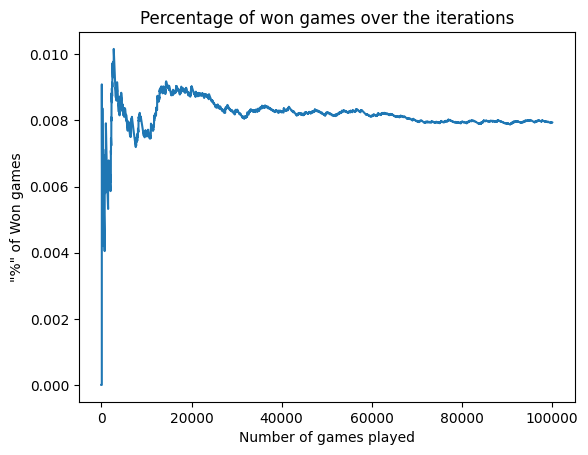

In [432]:
Q_table=Q_learning(sym=True,on_policy=True)
evaluate_Agent(Q_table,first=False,sym=True)

### Monte Carlo

In [416]:
def MC(on_policy = False, sym =False):
    
    Q = defaultdict(float)
    N = defaultdict(int)
    for _ in tqdm(range(200_000)):
        if on_policy:
            trajectory = agent_game_Q(Q,sym=sym)
        else:
            trajectory = random_game_Q()
        
        final_reward = action_value(trajectory[-1][0])

        for state, action in trajectory:
            # exploit symmetries
            if sym:
                state=compute_base_case(state)
            hashable_state = State(frozenset(state.x),frozenset(state.o))
            state_action = tuple((hashable_state,action))
           
            # Update N-values (visit count for state-action pairs)
            N[state_action] += 1

            # Update Q-value using incremental update rule
            Q[state_action] += (1 / N[state_action]) * (final_reward - Q[state_action])
    
    return Q

In [435]:
Q = MC(on_policy=True,sym=True)


  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [01:49<00:00, 1829.46it/s]


100%|██████████| 100000/100000 [00:25<00:00, 3916.83it/s]


The percentage of won/lost/drawn games for X is:  0.00332 0.6586 0.33808
The size of the table is : 10864


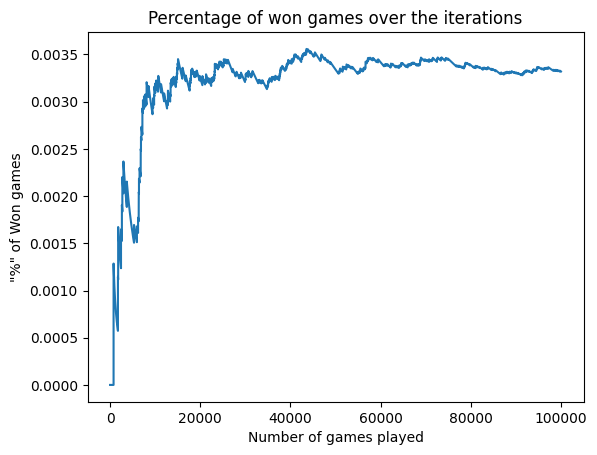

In [437]:
evaluate_Agent(Q,first=False,sym=True)